## CARE Denoising with Flywing dataset. 

This notebook demonstrates CARE denoising on the Flywing dataset, which shows a membrane labeled fly wing . The original dataset (n0) is publicly available at DenoiSeg-Wiki2. Two noisy versions were generated for DenoiSeg by adding pixel-wise independent Gaussian noise with zero-mean and standard deviations of 10 (n10) and 20 (n20). For this example we use the n0 and n20 data for CARE denoising. 

In [1]:
# Necessary imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tifffile
from scipy.ndimage import gaussian_filter
from careamics import CAREamist
from careamics.utils import autocorrelation
from careamics.config import create_care_configuration
from careamics.utils.metrics import scale_invariant_psnr
from microssim import micro_structural_similarity
from careamics_portfolio import PortfolioManager
from PIL import Image

/home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


###  Load the Flywing Dataset
- Flywing_n0: Clean data with no added noise (HIGH SNR / Ground Truth)
- Flywing_n20: Noisy data with noise level 20 (LOW SNR / Noisy Input)

In [2]:
data_root = Path("/group/jug/Diya/data")

# Load training data
train_low_data = np.load(data_root / "Flywing_n20" / "train" / "train_data.npz")
train_gt_data = np.load(data_root / "Flywing_n0" / "train" / "train_data.npz")

X_train = train_low_data['X_train']
Y_train = train_gt_data['X_train']

print(f"Training Data (Noisy): {X_train.shape}")
print(f"Training Data (GT): {Y_train.shape}")

# Load test data
test_low_data = np.load(data_root / "Flywing_n20" / "test" / "test_data.npz")
test_gt_data = np.load(data_root / "Flywing_n0" / "test" / "test_data.npz")

X_test = test_low_data['X_test']
Y_test = test_gt_data['X_test']

print(f"Test Data (Noisy): {X_test.shape}")
print(f"Test Data (GT): {Y_test.shape}")

Training Data (Noisy): (1428, 128, 128)
Training Data (GT): (1428, 128, 128)
Test Data (Noisy): (42, 512, 512)
Test Data (GT): (42, 512, 512)


### Visualize the data and prepare for training

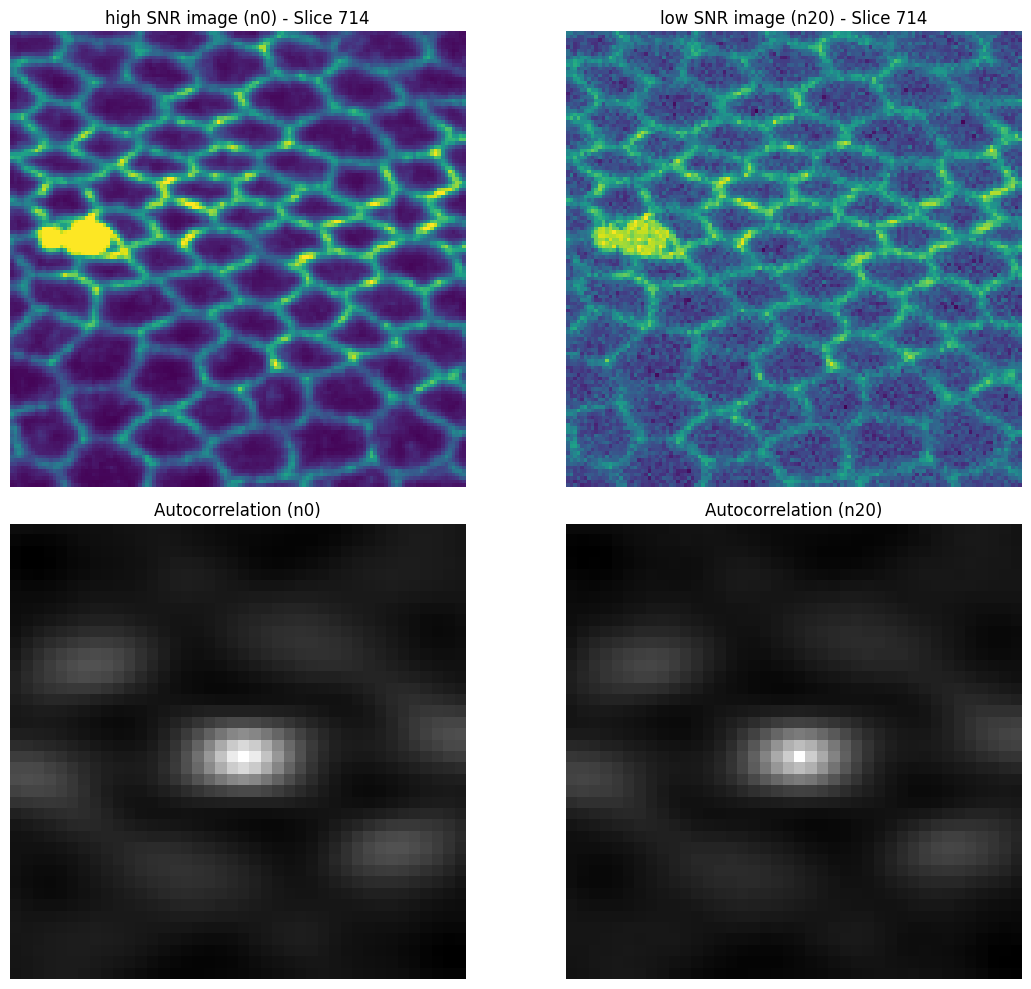

Training data: (1428, 128, 128) (ZYX)


In [3]:
# Visualize sample slices and autocorrelation
slice_idx = X_train.shape[0] // 2

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# n0
ax[0, 0].imshow(Y_train[slice_idx])
ax[0, 0].set_title(f"high SNR image (n0) - Slice {slice_idx}")
ax[0, 0].axis('off')

# n20
ax[0, 1].imshow(X_train[slice_idx])
ax[0, 1].set_title(f"low SNR image (n20) - Slice {slice_idx}")
ax[0, 1].axis('off')

# Autocorrelation of n0
autocorr_gt = autocorrelation(Y_train[slice_idx])
midpoint = autocorr_gt.shape[0] // 2
crop = 20
cropped_gt = autocorr_gt[midpoint-crop:midpoint+crop, midpoint-crop:midpoint+crop]

ax[1, 0].imshow(cropped_gt, cmap="gray")
ax[1, 0].set_title("Autocorrelation (n0)")
ax[1, 0].axis('off')

# Autocorrelation of n20
autocorr_noisy = autocorrelation(X_train[slice_idx])
cropped_noisy = autocorr_noisy[midpoint-crop:midpoint+crop, midpoint-crop:midpoint+crop]

ax[1, 1].imshow(cropped_noisy, cmap="gray")
ax[1, 1].set_title("Autocorrelation (n20)")
ax[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Prepare data for training
X_images = X_train.astype(np.float32)
Y_images = Y_train.astype(np.float32)

print(f"Training data: {X_images.shape} (ZYX)")

### Configure and train the CARE model

In [4]:
if X_images.ndim == 3:
    axes = "ZYX"
    patch_size = (8, 64, 64)
else: 
    axes = "SZYX" 
    patch_size = (8, 64, 64)

# Create CARE configuration
config = create_care_configuration(
    experiment_name="CARE_Flywing",
    data_type="array",
    axes=axes,
    patch_size=patch_size,
    batch_size=2,
    num_epochs=50,
)

careamist = CAREamist(config)
careamist.train(
    train_source=X_images,
    train_target=Y_images,
    val_percentage=0.1, 
    val_minimum_split=5, 
)

No working directory provided. Using current working directory: /home/diya.srivastava/Desktop/repos/careamics-examples/applications/care/denoising/3D.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40-16Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Extracted 812 patches from input array.
Computed dataset mean: [44.541397], std: [43.985687]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 1.5 M  | train
---------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.094     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 366/366 [00:05<00:00, 67.57it/s, train_loss_step=0.13, val_loss=0.13, train_loss_epoch=0.13]   

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 366/366 [00:05<00:00, 65.81it/s, train_loss_step=0.13, val_loss=0.13, train_loss_epoch=0.13]


### Predict on trained model

In [6]:
test_data = X_test.astype(np.float32)
test_n20 = Y_test.astype(np.float32)

print(f"Test n20 shape: {test_data.shape}")
print(f"Test n0 shape: {test_n20.shape}")

# Handle different data formats
if test_data.ndim == 4:
    # If we have multiple test stacks, predict on the first one
    predict_on = test_data[0]
    gt_compare = test_n20[0]
    axes_predict = "ZYX"
elif test_data.ndim == 3:
    predict_on = test_data
    gt_compare = test_n20
    axes_predict = "ZYX"
else:
    raise ValueError(f"Unexpected test data shape: {test_data.shape}")

print(f"Predicting on data shape: {predict_on.shape} ({axes_predict})")

# Perform prediction
predictions = careamist.predict(
    source=predict_on, 
    data_type="array",
    axes=axes_predict, 
    tile_size=(8, 128, 128),  
    tile_overlap=(4, 64, 64), 
    batch_size=2, 
    tta=False  
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Test n20 shape: (42, 512, 512)
Test n0 shape: (42, 512, 512)
Predicting on data shape: (42, 512, 512) (ZYX)
Predicting DataLoader 0: 100%|██████████| 245/245 [00:02<00:00, 84.12it/s]


### Visualize predictions and compute metrics

Predictions shape: (42, 512, 512) (ZYX)


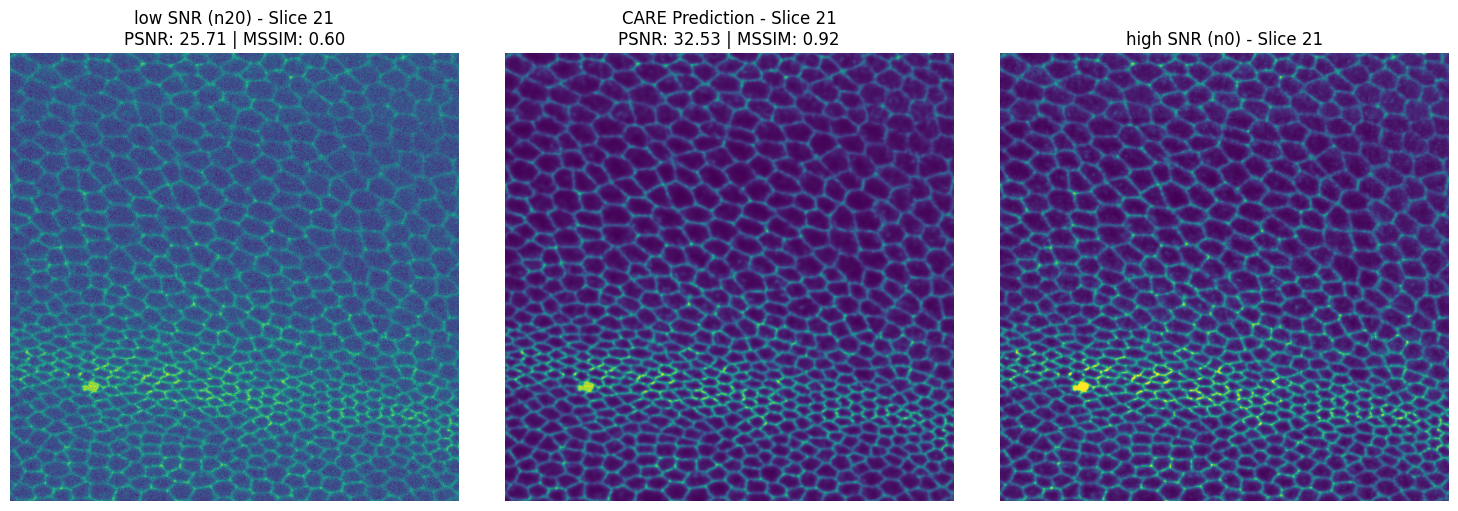

In [12]:
test_predictions = np.squeeze(np.array(predictions))
print(f"Predictions shape: {test_predictions.shape} (ZYX)")

psnr_noisy_list = []
psnr_pred_list = []
microssim_noisy_list = []
microssim_pred_list = []

for slice_idx in range(test_predictions.shape[0]):
    psnr_noisy_list.append(scale_invariant_psnr(predict_on[slice_idx], gt_compare[slice_idx]))
    psnr_pred_list.append(scale_invariant_psnr(test_predictions[slice_idx], gt_compare[slice_idx]))
    microssim_noisy_list.append(micro_structural_similarity(predict_on[slice_idx], gt_compare[slice_idx]))
    microssim_pred_list.append(micro_structural_similarity(test_predictions[slice_idx], gt_compare[slice_idx]))

# Calculate averages
avg_psnr_noisy = np.mean(psnr_noisy_list)
avg_psnr_pred = np.mean(psnr_pred_list)
avg_mssim_noisy = np.mean(microssim_noisy_list)
avg_mssim_pred = np.mean(microssim_pred_list)

# Select middle slice for visualization
slice_idx = predict_on.shape[0] // 2

# Get metrics for this specific slice
slice_psnr_noisy = psnr_noisy_list[slice_idx]
slice_psnr_pred = psnr_pred_list[slice_idx]
slice_mssim_noisy = microssim_noisy_list[slice_idx]
slice_mssim_pred = microssim_pred_list[slice_idx]

# Visualization
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(predict_on[slice_idx])
ax[0].set_title(f"low SNR (n20) - Slice {slice_idx}\nPSNR: {slice_psnr_noisy:.2f} | MSSIM: {slice_mssim_noisy:.2f}")
ax[0].axis('off')

ax[1].imshow(test_predictions[slice_idx])
ax[1].set_title(f"CARE Prediction - Slice {slice_idx}\nPSNR: {slice_psnr_pred:.2f} | MSSIM: {slice_mssim_pred:.2f}")
ax[1].axis('off')

ax[2].imshow(gt_compare[slice_idx])
ax[2].set_title(f"high SNR (n0) - Slice {slice_idx}")
ax[2].axis('off')

plt.tight_layout()
plt.show()

- test volume = (42, 512, 512)
- tiles =  (8, 128, 128)
- overlap =  (4, 64, 64)
- PSNR and MSSIM are calculated individually for each of the 42 predicted slices against each high SNR slice-


### Get losses

{'epoch': [], 'learning_rate': [], 'step': [], 'train_loss_epoch': [], 'train_loss_step': [], 'val_loss': []}


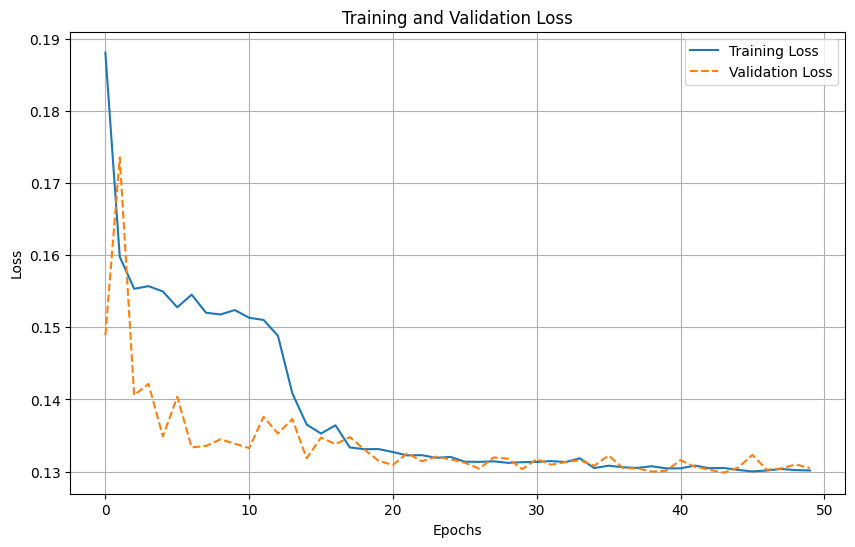

In [9]:
losses = careamist.get_losses()

train_losses = losses.get('train_loss', [])
val_losses = losses.get('val_loss', [])
train_epochs = losses.get('train.epoch', list(range(len(train_losses))))
val_epochs = losses.get('val.epoch', list(range(len(val_losses))))

plt.figure(figsize=(10, 6))
if train_losses:
    plt.plot(train_epochs, train_losses, label='Training Loss')
else:
    print("No training data found.")

if val_losses:
    plt.plot(val_epochs, val_losses, label='Validation Loss', linestyle='--')
else:
    print("No validation data found.")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.legend()
plt.show()

### Create a visualization for a comparison of before/after

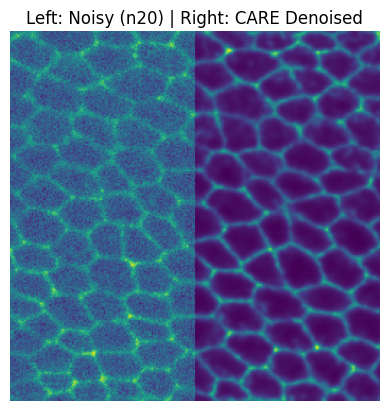

Cover image saved as Flywing_CARE.jpeg


In [11]:
# create a cover image
im_idx = predict_on.shape[0] // 2
x_min = 0
y_min = 0
size = 256

cv_image_noisy = predict_on[im_idx]
cv_image_pred = test_predictions[im_idx]


cover = np.zeros((size, size))
(height, width) = cv_image_noisy.shape
if height < size or width < size:
    size = min(height, width, 128)
    cover = np.zeros((size, size))

if height > size and width > size and y_min + size < height and x_min + size < width:
    norm_noise = (cv_image_noisy - cv_image_noisy.min()) / (
        cv_image_noisy.max() - cv_image_noisy.min()
    )
    norm_pred = (cv_image_pred - cv_image_pred.min()) / (
        cv_image_pred.max() - cv_image_pred.min()
    )

    cover[:, : size // 2] = norm_noise[y_min : y_min + size, x_min : x_min + size // 2]
    cover[:, size // 2 :] = norm_pred[y_min : y_min + size, x_min + size // 2 : x_min + size]

    plt.imshow(cover, cmap="viridis")
    plt.title("Left: Noisy (n20) | Right: CARE Denoised")
    plt.axis('off')
    plt.show()

    # save the image
    im = Image.fromarray(cover * 255)
    im = im.convert("L")
    im.save("Flywing_CARE.jpeg")
    print("Cover image saved as Flywing_CARE.jpeg")
else:
    print(f"Image too small ({height}x{width}) to create {size}x{size} cover image")

### And you're done! Now we can export the model to BMZ format

In [ ]:
im_idx = predict_on.shape[0] // 2
y_start = 0
x_start = 0
size = 256
z_slices = 8

z_start = max(0, im_idx - z_slices // 2)
z_end = min(predict_on.shape[0], im_idx + z_slices // 2)
actual_size = min(size, predict_on.shape[1], predict_on.shape[2])

test_input = predict_on[z_start:z_end, y_start:y_start+actual_size, x_start:x_start+actual_size].astype(np.float32)

In [ ]:
# Define description for the model
general_description = """
This model is trained using the CARE algorithm to denoise 3D fluorescence microscopy images 
of Drosophila melanogaster's membrane-labeled fly wing. The training data consists of paired noisy (n20) and 
clean (n0) 3D stacks, where n20 has synthetic noise added at level 20 and n0 represents the 
clean image.

CARE (Content-Aware Image Restoration) is a supervised deep learning method that learns to map 
noisy images to clean images by training on paired examples. The model uses a U-Net architecture 
trained on 3D patches, making it suitable for volumetric denoising of fluorescence microscopy data.

The notebook used to train this model is available on the CAREamics documentation website.
"""

# Export the model
careamist.export_to_bmz(
    path_to_archive="flywing_care_model.zip",
    friendly_model_name="Flywing_CARE",
    input_array=test_input,
    authors=[{"name": "CAREamics authors", "affiliation": "CAREamics Team"}],
    general_description=general_description,
    data_description="Membrane-labeled fly wing of Drosophila melanogaster: noisy (n20) and clean (n0) 3D fluorescence microscopy data"
)